# Project P1-Finding the lane lines

This project is to identify the lane lines on the road. It helps to learn the following concepts
- Color Selection
- Region Masking
- Gaussian Blur
- Canny Edge detection
- Hough transform

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Step 1: Read Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


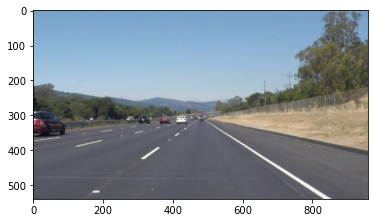

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Step 2: Convert the image to Grayscale

In [3]:
def grayscale(img):
    '''
    Applies the Grayscale transform.
    '''
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

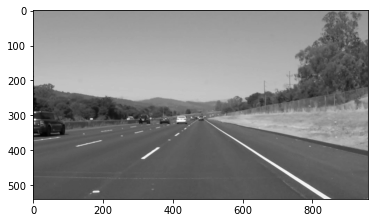

In [4]:
gray_img = grayscale(image)
plt.imshow(gray_img, cmap = 'gray')

## Step 3: Apply a Gaussian Noise Kernel

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

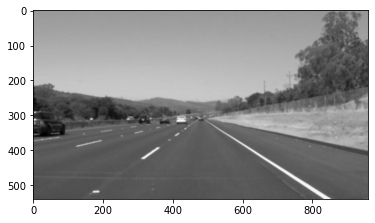

In [6]:
blur_gray = gaussian_blur(gray_img, kernel_size = 5)
plt.imshow(blur_gray, cmap='gray')

## Step 4: Apply Canny Transform

In [7]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

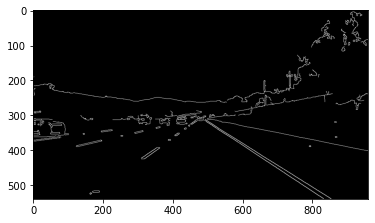

In [8]:
edges = canny(blur_gray, 40, 160)
plt.imshow(edges, cmap='gray')

## Step 5: ROI - Apply Regional Mask

In [9]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    vertices = np.array([[(0,edges.shape[0]),(500, 320), (490, 320), (edges.shape[1],edges.shape[0])]], dtype=np.int32)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

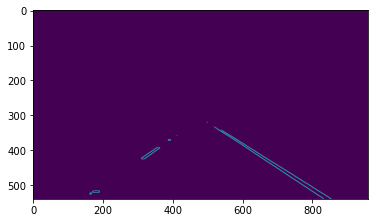

In [10]:
masked_edges = region_of_interest(edges)
plt.imshow(masked_edges)

## Step 6: Apply Hough Transform

In [11]:
def hough_lines(img, rho = 2, theta = np.pi/180, threshold = 19, min_line_len = 24, max_line_gap = 20):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

In [12]:
lines = hough_lines(masked_edges)
print(*lines)

[[498 320 796 514]] [[538 342 853 539]] [[310 422 355 392]] [[318 425 363 394]] [[800 518 832 538]] [[310 423 358 392]] [[715 462 765 494]] [[750 485 782 505]] [[522 335 696 448]] [[546 346 854 538]] [[319 424 363 392]]


## Step 6: Draw Lines

In [13]:
def draw_lines(lines, image):
    
    lane_image = np.copy(image)*0 #creating a blank to draw lines on
    lane_color = (255,0,0)
    lane_thickness = 10
    
    left_slopes = []
    left_intercepts = []
    
    right_slopes = []
    right_intercepts = []
    
    y_max = image.shape[0]
    y_min = lane_image.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = np.polyfit((x1, x2), (y1, y2), 1)
            y_min = min(y_min, y1, y2)
            if(m > 0):
                left_slopes.append(m)
                left_intercepts.append(b)
            if(m < 0):
                right_slopes.append(m)
                right_intercepts.append(b)
                
    if len(left_slopes) > 0: 
        # Draw the left lane
        left_slope = np.median(left_slopes)
        left_intercept = np.median(left_intercepts)
        left_x_min = int((y_min-left_intercept)/left_slope)
        left_x_max = int((y_max-left_intercept)/left_slope)
        cv2.line(lane_image, (left_x_min, y_min), (left_x_max, y_max), lane_color, lane_thickness)
    if len(right_slopes) > 0:
        # Draw the right lane
        right_slope = np.median(right_slopes)
        right_intercept = np.median(right_intercepts)
        right_x_min = int((y_min-right_intercept)/right_slope)
        right_x_max = int((y_max-right_intercept)/right_slope)
        cv2.line(lane_image, (right_x_min, y_min), (right_x_max, y_max), lane_color, lane_thickness)
    
    return cv2.addWeighted(image, 0.8, lane_image, 1, 0)

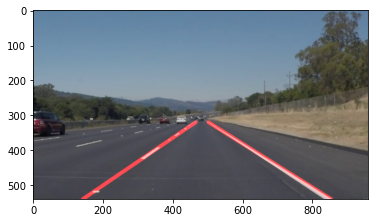

In [14]:
lanes = draw_lines(lines, image)
plt.imshow(lanes)

## Step 7: Final Solution Pipeline

In [15]:
def pipeline(image):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size = 5)
    edges = canny(blur_gray, 50, 150)
    masked_edges = region_of_interest(edges)
    lines = hough_lines(masked_edges)
    
    return draw_lines(lines, image)

## Step 7: Test the pipeline on the test images

### Test Images

Build your pipeline to work on the images in the directory "test_images"
You should make sure your pipeline works well on these images before you try the videos.


In [16]:
import os
image_names = os.listdir("test_images/")

### Test the pipeline

In [19]:
if not os.path.isdir("test_images_output"):
    os.mkdir("test_images_output")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    # Run the pipeline
    img_out = pipeline(img)
    # Save output
    mpimg.imsave(os.path.join("test_images_output/", test_images[i]), img_out)
    # Show output
    plt.figure()
    plt.suptitle(test_images[i], fontsize=20)
    plt.imshow(img_out)

NameError: name 'test_images' is not defined

## Step 8: Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
!pip install moviepy
from moviepy.editor import VideoFileClip
# from moviepy.editor import *
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip  
# %time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_clip))